In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor



In [39]:


def _clean_feat(col: str) -> str:
    return (
        col.replace("player_season_", "")
           .replace("_90", "")
           .replace("_improvement", " (I)")
           .replace("_", " ")
           .title()
    )

def run_xgb_per_position(df_in, position, target="value", top_k_features=40):
    subset = df_in[df_in["primary_position_group"] == position].copy()
    n = subset.shape[0]
    if n < 60:
        return {"position": position, "samples": n, "error": f"Not enough samples ({n})"}
    
    drop_cols = [
        "player_id","player_name","team_name","competition_id","sb_id",
        "competition_name","season_id","season_name","country_id",
        "birth_date","marketValue.determined","season","is_baseline",
        target,"primary_position_group"
    ]
    X = subset.drop(columns=drop_cols, errors="ignore")
    y = subset[target]

    # Clean
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

    # Keep top-variance features
    keep = X.var().sort_values(ascending=False).head(top_k_features).index
    X = X[keep]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model = XGBRegressor(
        n_estimators=10000, ##
        max_depth=20,
        learning_rate=0.02,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42,
        n_jobs=-1,
        reg_lambda=1,
        reg_alpha=0
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2  = r2_score(y_test, y_pred)

    # Importances (top 12)
    imp_series = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False).head(12)

    # Build tidy table with cleaned names
    importances_table = (
        pd.DataFrame({
            "feature_raw": imp_series.index,
            "importance": imp_series.values
        })
        .assign(
            feature_clean=lambda d: d["feature_raw"].map(_clean_feat),
            rank=lambda d: np.arange(1, len(d) + 1)
        )[["rank", "feature_raw", "feature_clean", "importance"]]
    )

    return {
        "position": position,
        "samples": n,
        "MSE": mse,
        "MAE": mae,
        "R²": r2,
        "top_features_raw": imp_series.index.tolist(),
        "top_features_clean": [ _clean_feat(c) for c in imp_series.index ],
        "importances": importances_table
    }


In [40]:
df = pd.read_csv('model_data/merged_season_data.csv',sep=',')
print(len(df), "total samples in dataset")
df = df[~df.isin([np.inf, -np.inf]).any(axis=1)]
print(len(df), "samples after cleaning")
df['primary_position_group'] = df['primary_position_group'].replace("Attacking Midfielder","Midfielder")

position_list = df['primary_position_group'].unique().tolist()

# Example runs:

results = []
for p in position_list:

    res_p = run_xgb_per_position(df, p)

    print(f"\n=== {p} ===")
    print({k: v for k, v in res_p.items() if k not in ("importances",)})
    results.append(res_p)
    try:
        print(res_p["importances"])
    except:
        pass



966 total samples in dataset
556 samples after cleaning

=== Centre Back ===
{'position': 'Centre Back', 'samples': 120, 'MSE': 2.883760737117882, 'MAE': 1.0161367113391557, 'R²': 0.31010437046493955, 'top_features_raw': ['player_season_obv_dribble_carry_90_improvement', 'player_season_deep_completions_90_improvement', 'player_season_sp_passes_into_box_90_improvement', 'player_season_obv_defensive_action_90_improvement', 'Elo', 'player_season_conversion_ratio_improvement', 'player_season_minutes', 'player_season_passes_inside_box_90_improvement', 'player_season_crosses_90_improvement', 'player_season_np_psxg_90_improvement', 'player_season_change_in_passing_ratio_improvement', 'player_season_yellow_cards_90_improvement'], 'top_features_clean': ['Obv Dribble Carry (I)', 'Deep Completions (I)', 'Sp Passes Into Box (I)', 'Obv Defensive Action (I)', 'Elo', 'Conversion Ratio (I)', 'Minutes', 'Passes Inside Box (I)', 'Crosses (I)', 'Np Psxg (I)', 'Change In Passing Ratio (I)', 'Yellow Cards 

In [50]:
results_df = pd.concat([pd.DataFrame([res]) for res in results], ignore_index=True).sort_values(by="R²",ascending=True)
results_df = results_df[results_df['error'].isna()]
results_df.to_csv('model_data/model_performance_summary.csv',index=False)

In [42]:
from gent_colors import colorDict

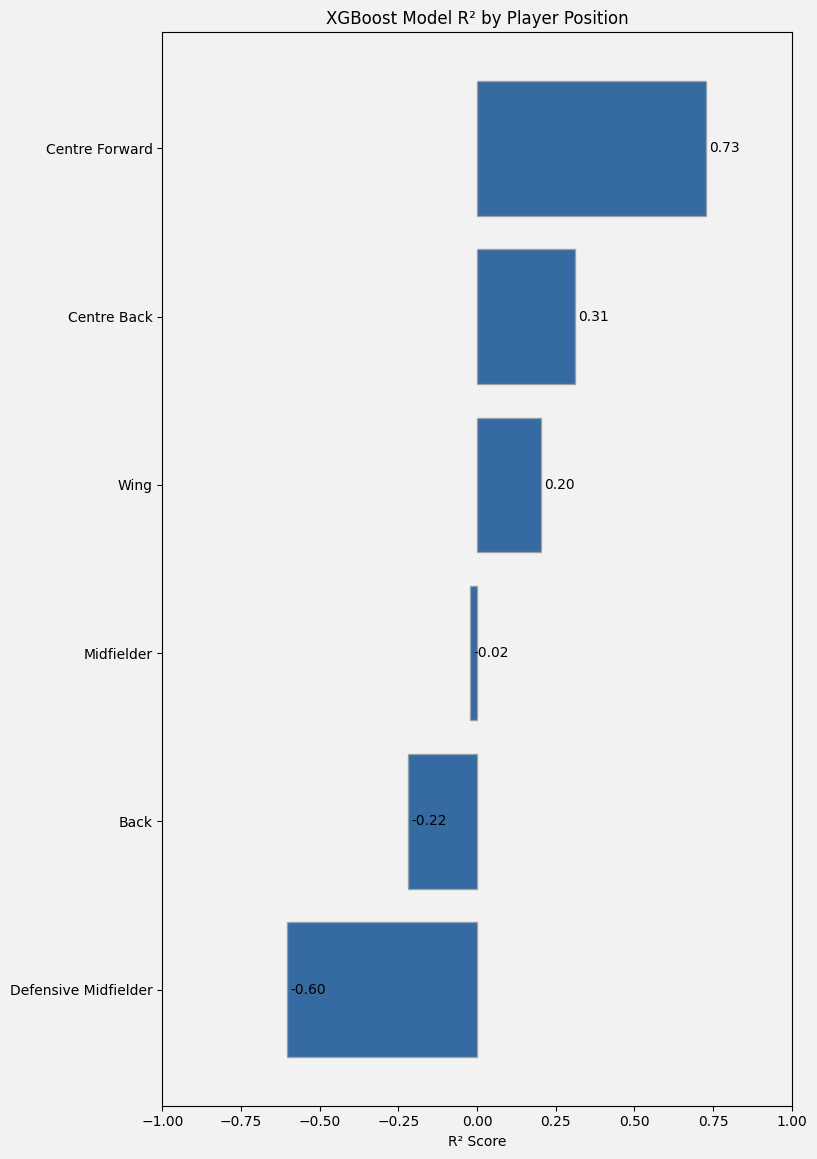

In [43]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(8.27,11.69))  # A4 size in inches
ax.set_facecolor(colorDict['RGB']['lightgrey'])
fig.patch.set_facecolor(colorDict['RGB']['lightgrey'])
results_df = results_df.sort_values(by="R²", ascending=True)
ax.barh(results_df['position'], results_df['R²'], color=colorDict['RGB']['darkblue'],edgecolor=colorDict['RGB']['darkgrey'],alpha=0.8)
ax.set_xlabel('R² Score')
ax.set_title('XGBoost Model R² by Player Position')
ax.set_xlim(-1, 1)

for i in range(len(results_df)):
    ax.text(results_df['R²'].iloc[i]+0.01, i, f"{results_df['R²'].iloc[i]:.2f}", va='center')
plt.tight_layout()

fig.savefig('data_viz/xgboost_r2_by_position.png', dpi=300)

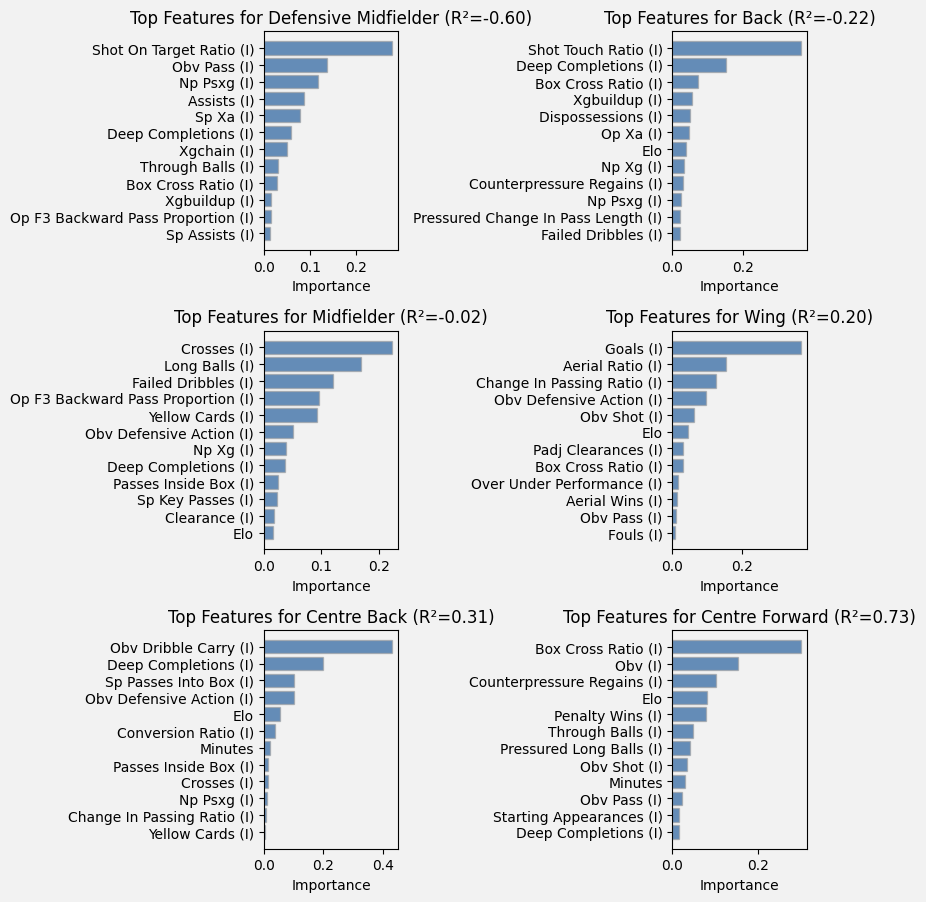

In [44]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(8.27, 11.69))  # A4 size
fig.patch.set_facecolor(colorDict['RGB']['lightgrey'])
ax = ax.flatten()  # easier to index
for i, (idx, row) in enumerate(results_df.iterrows()):
    imp_df = row['importances']
    ax[i].set_facecolor(colorDict['RGB']['lightgrey'])
    ax[i].barh(imp_df['feature_clean'], imp_df['importance'], color=colorDict['RGB']['darkblue'],
               alpha=0.6,edgecolor=colorDict['RGB']['darkgrey'])
    ax[i].set_title(f"Top Features for {row['position']} (R²={row['R²']:.2f})")
    ax[i].set_xlabel('Importance')
    ax[i].invert_yaxis()  # highest importance on top

# Hide unused axes
for j in range(i+1, len(ax)):
    ax[j].set_visible(False)           # remove background
    for spine in ax[j].spines.values():  # hide borders
        spine.set_visible(False)
    ax[j].get_xaxis().set_visible(False)
    ax[j].get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

fig.savefig('data_viz/xgboost_top_features_by_position.png', dpi=300)


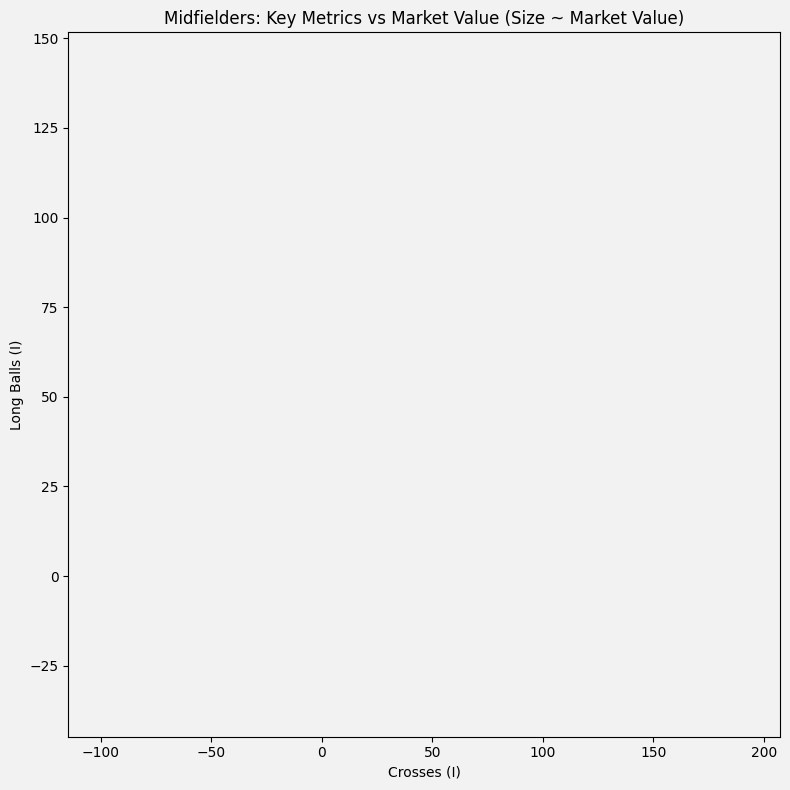

In [45]:
mids = df[df['primary_position_group']=='Midfielder']
metrics = results_df[results_df['position']=='Midfielder']['importances'].values[0]['feature_raw'][0:2].tolist()

mids = mids[['player_name','value']+metrics].dropna()

fig, ax = plt.subplots(figsize=(8,8))  # A4 size in inches
ax.set_facecolor(colorDict['RGB']['lightgrey'])
fig.patch.set_facecolor(colorDict['RGB']['lightgrey'])
ax.scatter(mids[metrics[0]], mids[metrics[1]], s=mids['value']/1000000, alpha=0.6, color=colorDict['RGB']['darkblue'], edgecolor=colorDict['RGB']['darkgrey'])
ax.set_xlabel(_clean_feat(metrics[0]))
ax.set_ylabel(_clean_feat(metrics[1]))
ax.set_title('Midfielders: Key Metrics vs Market Value (Size ~ Market Value)')
plt.tight_layout()
plt.show()

In [46]:
mids

,player_name,value,player_season_crosses_90_improvement,player_season_long_balls_90_improvement
159,Hans Vanaken,10.00,-36.420988,12.877678
168,Pieter Gerkens,2.00,-23.375277,-18.346794
173,Francis Amuzu,5.50,6.395782,27.674919
261,Yari Verschaeren,7.50,57.797101,126.833335
262,Yari Verschaeren,8.50,-48.325172,-18.555976
275,Kerim Mrabti,3.50,-3.768922,30.446578
318,Massimo Bruno,0.30,-100.000000,-15.476627
348,Xavier Mercier,0.25,-47.960942,-35.909343
356,Geoffry Hairemans,0.50,-13.201360,-30.703174
375,Casper Nielsen,6.50,112.424774,-20.993890


In [47]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def run_xgb_global(df_in, target="value", top_k_features=40):
    # Columns to drop (keep primary_position_group to encode)
    drop_cols = [
        "player_id","player_name","team_name","competition_id","sb_id",
        "competition_name","season_id","season_name","country_id",
        "birth_date","marketValue.determined","season","is_baseline",
        target
    ]
    X = df_in.drop(columns=drop_cols, errors="ignore").copy()
    y = df_in[target].copy()

    # One-hot encode position (and any other low-card categorical, if you wish)
    # Here we only OHE the position; everything else assumed numeric already.
    X = pd.get_dummies(X, columns=["primary_position_group"], drop_first=False)

    # Clean
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

    # Keep top-variance features BUT ensure we don't drop all position dummies
    pos_cols = [c for c in X.columns if c.startswith("primary_position_group_")]
    # Temporarily exclude position columns when selecting by variance
    variances = X.drop(columns=pos_cols, errors="ignore").var(numeric_only=True)
    keep_numeric = variances.sort_values(ascending=False).head(max(0, top_k_features - len(pos_cols))).index
    keep = list(keep_numeric) + pos_cols
    keep = [c for c in keep if c in X.columns]
    X = X[keep]

    # Split (optionally stratify by position to keep proportions)
    pos_for_strat = df_in["primary_position_group"] if "primary_position_group" in df_in else None
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=pos_for_strat
    )

    model = XGBRegressor(
        n_estimators=5000,
        max_depth=10,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42,
        n_jobs=-1,
        reg_lambda=1,
        reg_alpha=0,
        tree_method="hist"
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2  = r2_score(y_test, y_pred)

    imp_series = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False).head(12)
    importances_table = (
        pd.DataFrame({"feature_raw": imp_series.index, "importance": imp_series.values})
        .assign(feature_clean=lambda d: d["feature_raw"].map(_clean_feat),
                rank=lambda d: np.arange(1, len(d) + 1))
        [["rank","feature_raw","feature_clean","importance"]]
    )

    return {
        "samples": len(df_in),
        "MSE": mse, "MAE": mae, "R²": r2,
        "top_features_raw": imp_series.index.tolist(),
        "top_features_clean": [_clean_feat(c) for c in imp_series.index],
        "importances": importances_table,
        "feature_names": X.columns.tolist()
    }


In [48]:
global_model = run_xgb_global(df, target="value", top_k_features=40)

In [49]:
global_model['top_features_clean']

['Clearance (I)',
 'Obv (I)',
 'Op Assists (I)',
 'Assists (I)',
 'Pressured Change In Pass Length (I)',
 'Npg (I)',
 'Goals (I)',
 'Sp Key Passes (I)',
 'Padj Clearances (I)',
 'Box Cross Ratio (I)',
 'Deep Completions (I)',
 'Failed Dribbles (I)']